In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# !git clone https://github.com/kteavery/transformers.git
# %pwd 
# %cd transformers
!pip install git+https://github.com/kteavery/transformers.git

# !pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

!pip install rouge/requirements.txt
!pip install rouge-score

  Cloning https://github.com/kteavery/transformers.git to /tmp/pip-req-build-h08lxo77
  Running command git clone -q https://github.com/kteavery/transformers.git /tmp/pip-req-build-h08lxo77
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 895 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 36.1 MB/s 
     |████████████████████████████████| 3.3 MB 29.5 MB/s 
     |████████████████████████████████| 61 kB 446 kB/s 
  Created wheel for transformers: filename=transformers-4.13.0.dev0-py3-none-any.whl size=3277289 sha256=0f763103ae44fd8e73b1f4a1955a7f99b3cffc2da355c5b4d15e3f6002c269ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-h69ynis6/wheels/5c/6f/aa/8f3f015ceb7aaef1c732ad3f606d4d97c70222c503b4870189
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully un

In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


In [5]:
import os
import time
# from google.colab import drive

import json
import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(0)

# import transformers.src.transformers as transformers
# from transformers.src.transformers.models.gpt2.modeling_gpt2 import GPT2LMHeadModel
# from transformers.src.transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast
# from transformers.src.transformers.models.gpt2.configuration_gpt2 import GPT2Config

# from transformers.src.transformers.optimization import AdamW, get_linear_schedule_with_warmup

from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Config, AdamW, get_linear_schedule_with_warmup

from datasets import load_dataset
from helper import format_time, rouge
from data import GPT2Dataset, preprocessing, split_data
from plots import loss_curves

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="/content/drive/MyDrive/CS685" )

Downloading:   0%|          | 0.00/3.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Using custom data configuration en-c080136eb0615511


0 examples [00:00, ? examples/s]

Dataset covid_qa_ucsd downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_ucsd/en-c080136eb0615511/1.0.0/2a15b6e8fdc7cee91951d8f20ac2b26ede79fbef988919fbde22dbb97bf4df81. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
cd_df = covid_dialog['train'].to_pandas()
print(len(cd_df))
cd_df.head()

572


,dialogue_id,dialogue_url,dialogue_turns
0,1,https://www.icliniq.com/qa/covid-19/i-have-cou...,"{'speaker': [0, 1, 0, 1], 'utterance': ['I hav..."
1,2,https://www.icliniq.com/qa/covid-19/i-have-a-l...,"{'speaker': [0, 1, 0, 1, 0, 1, 0, 1], 'utteran..."
2,3,https://www.icliniq.com/qa/coronavirus/can-cor...,"{'speaker': [0, 1], 'utterance': ['Can Coronav..."
3,4,https://www.icliniq.com/qa/covid-19/i-have-chi...,"{'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ..."
4,5,https://www.healthcaremagic.com/premiumquestio...,"{'speaker': [0, 1], 'utterance': ['Does COVID-..."


In [8]:
qa_df = preprocessing(cd_df)
text = qa_df.text.copy()

qa_df.head()

/content/data.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_fields = np.transpose(np.array(all_fields).reshape((4, -1)))


,id,encoder,decoder,text
0,0,[I have cough with no travel history. Is this ...,"[Hello, I understand your concern. I just have...",[I have cough with no travel history. Is this ...
1,0,[I have cough with no travel history. Is this ...,"[Hi, I would recommend you take n-acetylcystei...",[I have cough with no travel history. Is this ...
2,1,[I have a little fever with no history of fore...,"[Hello, I can understand your concern.In my op...",[I have a little fever with no history of fore...
3,1,[I have a little fever with no history of fore...,"[Hi, yes, upload in this query only. I will se...",[I have a little fever with no history of fore...
4,1,[I have a little fever with no history of fore...,"[Hi, I can understand your concern. I have gon...",[I have a little fever with no history of fore...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


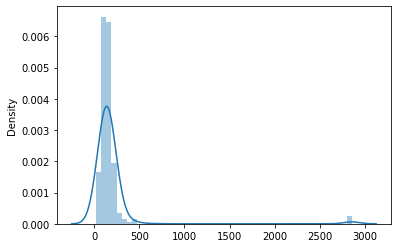

In [9]:
doc_lengths = []

for bio in text:
  
    # get rough token count distribution
    tokens = nltk.word_tokenize(bio[0])

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [10]:
torch.cuda.empty_cache()

In [11]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
config = GPT2Config.from_pretrained("microsoft/DialoGPT-small")
tokenizer = GPT2TokenizerFast.from_pretrained("microsoft/DialoGPT-small")
model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small", config=config)
print(model.config)


Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

GPT2Config {
  "_name_or_path": "microsoft/DialoGPT-small",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "conversational": {
      "max_length": 1000
    }
  },
  "transformers_version": "4.13.0.dev0",
  "use_cache": true,
  "vocab_size": 50257
}



In [12]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token

unique_vals = qa_df.id[len(qa_df)-1]

# Split into training and validation sets
train_size = int(0.8 * unique_vals)
val_size = int(0.1 * unique_vals)
test_size = unique_vals - train_size - val_size

train_split, val_split, test_split = split_data(qa_df, [train_size, val_size, test_size])

train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)
test_split.reset_index(drop=True, inplace=True)

print(train_split.head())

print("length of dataset: " + str(unique_vals))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

train_dataset = GPT2Dataset(train_split, tokenizer, max_length=768)
val_dataset = GPT2Dataset(val_split, tokenizer, max_length=768)
test_dataset = GPT2Dataset(test_split, tokenizer, max_length=768)

    id  ...                                               text
0  515  ...  [I travelled to Mauritius and do not have symp...
1  304  ...  [Because I have type 1 diabetes, what is likel...
2  329  ...  [I was confirmed to have covid-19, I self-isol...
3  180  ...  [Good morning I have sore throat for 2 days no...
4  313  ...  [I've been having the same symptoms as for Cor...

[5 rows x 4 columns]
length of dataset: 571
  456 training samples
   57 validation samples
   58 test samples


In [13]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [14]:
useCuda = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cuda


In [15]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# if torch.cuda.is_available() and useCuda:
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [16]:
# some parameters I cooked up that work reasonably well
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [18]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [19]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[5].to(device)
        b_labels = batch[5].to(device)
        b_masks = batch[6].to(device)
        b_prefix_masks = batch[3].to(device)
        # print(b_input_ids)
        model.zero_grad()        

        outputs = model(b_input_ids,
                          labels=b_labels, 
                          prefix_mask = b_prefix_masks,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    min_length = 50,
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[5].to(device)
        b_labels = batch[5].to(device)
        b_masks = batch[6].to(device)
        b_prefix_masks = batch[3].to(device)

        with torch.no_grad():        

            outputs  = model(b_input_ids, 
                             prefix_mask = b_prefix_masks,
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  

            if step % 2 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

              sample_outputs = model.generate(
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    min_length = 50,
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
              for i, sample_output in enumerate(sample_outputs):
                    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     1  of    228. Loss: 5.290461540222168.   Elapsed: 0:00:02.
0: ...............................................................................


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     2  of    228. Loss: 5.6141743659973145.   Elapsed: 0:00:04.
0: .......,.,.,,,.,..,,,,,,..,.,.,.,,,,,,,,,,,,,,,,,,,.,,,,,,,,,,,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     3  of    228. Loss: 3.8802638053894043.   Elapsed: 0:00:06.
0: ,..,,,,.,,?,,?.,....,?,.,.,.?,,.,.,..,.,.,.,....,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     4  of    228. Loss: 4.2494988441467285.   Elapsed: 0:00:07.
0: .,,..,......,.?........?,......,,., '....,.!!,.,,....?,...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     5  of    228. Loss: 7.989079475402832.   Elapsed: 0:00:09.
0: 2ch RES RES nsfw bing link 1 j bb RES u jst 3 2 yay 3u 3 3?? i dont really even know but RES can do everything here with some help. EDIT : not sure if RES can do that, but yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     6  of    228. Loss: 3.044290065765381.   Elapsed: 0:00:11.
0: 2ch F1 SNSR KAT DNB 3k 3k DNL 4.jp F amp F KSP B5f 2z2k F amp F KSP 6.0. 0 amp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp amp nbsp


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     7  of    228. Loss: 2.1413116455078125.   Elapsed: 0:00:14.
0: NSRl DRO 3 2 2 30 r 2 2 2 1 15 r 3 2 1 2 3 3 4 30 r 3 1 1 1 30 6 3 5 1 x 1 x 2 x x 0 x 2 3 1 1 5 r 3 x 1 x 1 x 2 x 2 x 1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     8  of    228. Loss: 2.41884183883667.   Elapsed: 0:00:17.
0: DV Fw 1000 SVF AT SLK SVF EZ 1 M SVF 5 SVF 7 SVF FW 1 Fw 0ff0f 0f 0f0f0f 0f 10 20 Fw 0f00 10f50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     9  of    228. Loss: 2.185551166534424.   Elapsed: 0:00:19.
0: ,.,,,..,,.,?,?...,....,???,.,,,.?,.,,,?,,?,,.,.,.,.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of    228. Loss: 4.288002967834473.   Elapsed: 0:00:21.
0: 30 5 15 20 60 20 30 4 5 5 5 20 3 1 2 3 1 2 5 30 6 5 10 30 5 15 20 30 3 3 30 5 10 15 3 10 30 35 5 30 4 5 3 30 3 5 30 4 45 45


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    11  of    228. Loss: 1.7716245651245117.   Elapsed: 0:00:22.
0: 2ch SNS VB SNS PM 2ch SNS PM SNS 3 SNS YSK SNS SP 5 SNS SP NS 2ch SNS YSK SNS SNS 3 SNS YSK Edit : SNS I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    12  of    228. Loss: 2.0304412841796875.   Elapsed: 0:00:24.
0: 1 100 100 1000 1 10 1 200 1 1 200 1 500 1 30 1 1 100 1 250 1000 1000 100 1 200 1 200 50 100 100 100 100 30 30 50 100 1 100 20 I'm so happy I have you RES here for a week


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    13  of    228. Loss: 1.6779959201812744.   Elapsed: 0:00:26.
0: Google,,....,.,..,.......,.!.,.!,....!..,..?...!....,.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    14  of    228. Loss: 2.86989688873291.   Elapsed: 0:00:28.
0: .?.,...?...?........?!!!!!!!!!!!!!! 1,..... 1? 1? 1?!!?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    15  of    228. Loss: 2.9398467540740967.   Elapsed: 0:00:30.
0: The correct answer would have been something like, we could use some of these for the new and improved BUD 9. So instead of a BUD 8 it should be an A A E in this case, as it is an in between.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    16  of    228. Loss: 1.685241937637329.   Elapsed: 0:00:32.
0: 5 2 3 1 100 3 3 2 1 1 1 3 100 3 1 1 1 3 100 50 1 1 1 1 100 100 100 100 100 50 50 60 100 100 60 35 30 1 1 1 1 1 1 100 100 5 3 3 1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    17  of    228. Loss: 2.163978099822998.   Elapsed: 0:00:34.
0: ?,,,,,,,,, 10, 20's you, the video was a while after it was uploaded and he also had the video with the time in the video that he was just like... you could have watched that


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of    228. Loss: 2.3626275062561035.   Elapsed: 0:00:36.
0: ? I don't get it... what is it that I'm missing? I can't see anything about the quote I quoted it from to understand it, but it would be more like I was my life is like the light to me if I'm that person.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    19  of    228. Loss: 1.297764778137207.   Elapsed: 0:00:38.
0: ...,.,.,.?, 10.,.,. 10..!!!,,., 10. 10... and my first in the middle or left if I'm taking a line in my last comment.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of    228. Loss: 1.9292171001434326.   Elapsed: 0:00:40.
0: ,.. 10.. 20.. 20!. 20... 10 30.. 10 10. 10 20 20. 20 30 90.8 20.4,20,100,000,000.24.000,9.8


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    21  of    228. Loss: 1.9443591833114624.   Elapsed: 0:00:42.
0: That's a lot of chugs. You need to have a go with a lot of chugs and or a lower one for it to be as easy as the two do the body's first and the other's first chug, to get the desired length of the chug.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    22  of    228. Loss: 1.4118680953979492.   Elapsed: 0:00:44.
0: Dv W2.txt W2.txt W2.txt W2.txt w2.txt w2.txt W2.txt.txt W2.txt.wav W2.txt W2.txt.wav W2.txt


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    23  of    228. Loss: 1.695923924446106.   Elapsed: 0:00:46.
0: .,..,..,.,, :,.,,., 2. 3 3. 3,5,,,.. 2,, 3.5. I think the number you are using is a bit off.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    24  of    228. Loss: 2.3987560272216797.   Elapsed: 0:00:48.
0: .,,,.,.., :P a. a for a brief sentence and the last two are in a zig for you can't do. If that's what you meant by the sentence or a to get a sentence to end on and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    25  of    228. Loss: 2.112415313720703.   Elapsed: 0:00:50.
0: ,,. ',,'and. It can be done with an and or for a full table in the text but you know it from the back of the page it's just a weird syntax. It should be in the text body of the text or the back of the text body


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    26  of    228. Loss: 1.55567467212677.   Elapsed: 0:00:52.
0: ?...,..,.,...,..,.,.,,.,.,.,,,. 20 20,2,3.21, 19,20.25 20.2.5 10.19.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    27  of    228. Loss: 2.1725687980651855.   Elapsed: 0:00:54.
0: .,.?..,.?.......?.....? 14 20,18 19,19.19,19,19.19,19.19.19.19.19,19,19.19,19.19,19,19,19,19.19.19,19,19.19.19.19,19.19,19.19,19.19,19,19.19.19.19.19,19.19,19.19.19,19.19,19.19,19.19,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    28  of    228. Loss: 1.934444546699524.   Elapsed: 0:00:58.
0: ., 10 30 250.. 20 10 20,,,.. 30 20 250. 21,.40. 30.60.. 2:. 20, 30.80.,.80.1 20.20, 8.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    29  of    228. Loss: 2.241332769393921.   Elapsed: 0:00:59.
0: ,.. I know you are being sarcastic but your sentence makes me think you are having a go at the user and a lot of the other comments to use as a question to you would make the same exact question. You should just have a short answer in your text and a few days of text to text


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of    228. Loss: 1.208479881286621.   Elapsed: 0:01:02.
0: , a.facebook.com.tbs.u.chilid.q.aol.aol.com.chilid.com.on.my.facebook.com.in or to.facebook.com.en.on.on.com.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    31  of    228. Loss: 2.470372200012207.   Elapsed: 0:01:04.
0: ... and the answer to your next question can you be a little bit more specific like your questions about the time at which a phone was the last of the days and the day at which you were the last of the days is a text from the last of the days and the answer is


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    32  of    228. Loss: 1.1987510919570923.   Elapsed: 0:01:06.
0: ,.,.....,.,,.,.,,. or. you know,,,., the the I you should do the right and you have to go to your doctor to get a test next to your doctor's or this


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    33  of    228. Loss: 1.119616985321045.   Elapsed: 0:01:08.
0: 4,3 4,3 4,2 8,2 14.15.20,19,19.19.20,19.20.20,20.19.20,1920,20,1920.20.1919.19,20


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    34  of    228. Loss: 2.9707629680633545.   Elapsed: 0:01:10.
0: , 10.? 10. a. s for the answer to you have to your question as well or an a or is a text at the next to the user when asked for it or when you have the answer for a year or so as the answer was there but someone will know what you are talking about


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    35  of    228. Loss: 1.644526481628418.   Elapsed: 0:01:12.
0: ? and you will know you have a better one when you have to know you've been around me and you know your old and have to know you're still around you'll be a better and it will probably take the rest of you a few days to talk to me and get there.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    36  of    228. Loss: 1.6742570400238037.   Elapsed: 0:01:14.
0: .,,,......,.. 10,15 20.. 10 15.20 15,20 15.30,30. 15,10 20,20,20,20 or 20,20,20,30.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    37  of    228. Loss: 1.3245735168457031.   Elapsed: 0:01:16.
0: ... s.r.lyc.b.h.c.m.l.p.r.l.p.c.c.c. a.p.l.ny.b.p.p.r.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    38  of    228. Loss: 1.3561323881149292.   Elapsed: 0:01:18.
0: ,....,, to: to: to: and the day of the doctor's to: Friday 19:00 to: 20:00 to: Thursday 19:30, in: to: to the day of the Doctor and to:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    39  of    228. Loss: 1.5681182146072388.   Elapsed: 0:01:20.
0: 2ch 15 2:1:25:18.5:19:25.0.19.23.3,0.3.0.19.20.0.0.19.21.19.19.21.2.19.1919.8.2


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of    228. Loss: 1.264114260673523.   Elapsed: 0:01:22.
0: 10 10 7,9 7,4 2,7 for now.In a week you will get one and you can do it to for the first time since the 3 days or you will get a text from the next week and a text from a year or so or your last text for the day this message.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    41  of    228. Loss: 1.7538937330245972.   Elapsed: 0:01:24.
0: DV R for Dv or or a VD V or DV for a VD or DV or a VD or a VD The VD V for VE V is not a VD V is a V V to V D


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    42  of    228. Loss: 1.7191039323806763.   Elapsed: 0:01:26.
0: ,  ile.mov and ile.mov.zip for your video video. video.mp3 is like a video out of the video.avid to the iphone iphone id  ile.mov.zip


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    43  of    228. Loss: 2.8446037769317627.   Elapsed: 0:01:28.
0: , text and text are two very very important and important text and text text. and text text is text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    44  of    228. Loss: 1.5776301622390747.   Elapsed: 0:01:33.
0: MOD 3changbong chat.chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.Chat.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    45  of    228. Loss: 0.9900795221328735.   Elapsed: 0:01:36.
0: .??? 19 20 20,19 21,19 19,19 19,19 19,19 21,19 19,19 19,19 19,19 19,19 19,19 19,19 19,19 19,19 21 19,1919 19,19 21,19 19,19 19,19 19,19 191919 19,19 19,191919 19,1919 1919 19,1919,1919 19,191919 19,1919,1919 19,19,19 19,19,19,19 19,1919 19,1919 19,19


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    46  of    228. Loss: 1.1969412565231323.   Elapsed: 0:01:39.
0: .., 19:19:19:19,19:19,19:1919:1919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    47  of    228. Loss: 1.1672160625457764.   Elapsed: 0:01:44.
0: .? Is the answer in the text post text post text or text text text post text post text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    48  of    228. Loss: 0.896226167678833.   Elapsed: 0:01:48.
0: .... 19,19,19,191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    49  of    228. Loss: 0.8761280179023743.   Elapsed: 0:01:53.
0: DVF JW is the next for the JW in the family to take a short and short to follow as they come up with the next JW and follow the next one up and then another JW and the next and so on and so on


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    228. Loss: 1.381339430809021.   Elapsed: 0:01:55.
0: ,                                                                                                                             


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    51  of    228. Loss: 0.9334609508514404.   Elapsed: 0:01:58.
0: 5:1:5:3:3:5:3:3:3: 4:1:3:5:3:3:3:5,3,3:3:3:3:3,3,3:2:3:3:3,3,3:1:3,3,3,3:3:3:3,3,3:3,3,3,3,3,3,3,3,3,3,3:3,3,3,3,1:1:3,1,3,3,3:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    52  of    228. Loss: 1.5420434474945068.   Elapsed: 0:02:02.
0: ?                                                                                                                             a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    53  of    228. Loss: 1.187430739402771.   Elapsed: 0:02:05.
0: , ian                                                                                                                          ,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    54  of    228. Loss: 1.3567795753479004.   Elapsed: 0:02:09.
0: ..?......,... but the video is not very video and not a video video of any video of any video video and then video text and text to video and video text video video video text video video video video video video video text and text video text video video video video and text video video video video video text text video text video video text video video text video video text video text video video text text text text text text video text text video text text video video text text video text text video text text text text text text text text text text text text text text text text text text text text


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    55  of    228. Loss: 1.9973748922348022.   Elapsed: 0:02:12.
0: ,?? or should be to be. Is this what you like to do with your text chat on chat.net chat or chat.in chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chatChat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat c

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    56  of    228. Loss: 1.1393085718154907.   Elapsed: 0:02:17.
0: ,                                                                                                                           


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    57  of    228. Loss: 0.7585654258728027.   Elapsed: 0:02:20.
0: ,                                                                                                                             !


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    58  of    228. Loss: 0.9008192420005798.   Elapsed: 0:02:24.
0: ,,! 19,2,1919,19191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919451919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    59  of    228. Loss: 0.831963300704956.   Elapsed: 0:02:29.
0: 1 7,3 7,3 7,3.5 7,3,4,3,5 7,5,5,5,5,5,5,5,5,5,5,5,5,5,5,3,6,5 7,5,5,5,5,5,5,5,5,5,5,3,5,5,1,4,3,5,5,4,5,5,5,1,6,5,5,3,5,5,0,5,4,3,5,6


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of    228. Loss: 1.1661297082901.   Elapsed: 0:02:32.
0: , is a better way to do it than text or video text text chat chat chat chat text chat text chat text chat text chat chat chat chat chat chat chat chat chat chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chattwitter chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    61  of    228. Loss: 0.9676563739776611.   Elapsed: 0:02:37.
0: ?                                                                                                                          


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    62  of    228. Loss: 1.311146855354309.   Elapsed: 0:02:40.
0: ,, 2,,?., 2,?,. 3,:D:D:D:D, D:D, 4,1,19,19:,19:19,19:1919,1919,191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    63  of    228. Loss: 1.424062728881836.   Elapsed: 0:02:45.
0: :P:p:p:p:m.wcg.us.fnc.k.fncw.fnc.scot.us.scot.m.nnc.qc.a.qc.c.s.i.qc.c: nc.m.cc.t.m.zc.s.m.lc.cbcbc.cbc.wcbc.sbcbc.cbc?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    64  of    228. Loss: 1.3236913681030273.   Elapsed: 0:02:48.
0: ..                                                                                                                         !


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    65  of    228. Loss: 0.7613869309425354.   Elapsed: 0:02:52.
0: 20,500,000 people or less and or what is this now a country in the world like most of people do this but are a country or is like a nation of people who do this or do it because you like what they do do and what the most and can do what they do out of their text chat chat chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chattext chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat cha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    66  of    228. Loss: 0.6391100883483887.   Elapsed: 0:02:57.
0: ...? Do you have this on video now for video chat with chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    67  of    228. Loss: 1.3627586364746094.   Elapsed: 0:03:00.
0: .                                                                                                                     


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    68  of    228. Loss: 2.2997758388519287.   Elapsed: 0:03:03.
0: ?                                                                                                                           !


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    69  of    228. Loss: 1.509190559387207.   Elapsed: 0:03:07.
0: , and you just text chat on text chat. chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat Chat chat chat, text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat c

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of    228. Loss: 0.7252339720726013.   Elapsed: 0:03:12.
0: : o: l:: o:? o:? : o:?  o:? o: o:  am I out of touch or did text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    71  of    228. Loss: 1.2277332544326782.   Elapsed: 0:03:17.
0: ,                                                                                                                          ?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    72  of    228. Loss: 0.6414117813110352.   Elapsed: 0:03:20.
0: edit: O P M P P M P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P P


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    73  of    228. Loss: 1.9709153175354004.   Elapsed: 0:03:24.
0: ?                                                                                                                        


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    74  of    228. Loss: 2.3264684677124023.   Elapsed: 0:03:27.
0: ?                                                                                                   


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    75  of    228. Loss: 0.976051926612854.   Elapsed: 0:03:30.
0: 1,2,3,5,6,10,15,15,16,20,20,19,19,19,19,19,20,19,19,19,20,19,19,19,19,19,19,19,19,19,19,1919,19,1919,19,1919,19,19,19,1919,19,19,19,19,1919,1919,1919,19,19,19,19,19,19,19,19,19,19,19,1919,1919,19,19,1919,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,1919,19,19,19,191919,19,19,19,19,19,1919,19,19,19


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    76  of    228. Loss: 0.8824108839035034.   Elapsed: 0:03:35.
0: ? but but but but but what about the text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat, chat.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    77  of    228. Loss: 1.1641712188720703.   Elapsed: 0:03:38.
0: ?                                                                                                                      ,    Hi.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    78  of    228. Loss: 1.2070801258087158.   Elapsed: 0:03:42.
0: , 2:1,2,3,5,6, 7,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    79  of    228. Loss: 1.13164222240448.   Elapsed: 0:03:45.
0: , text chat text chat text chat text chat chat chat text chat text chat chat text chat chat text chat chat text chat text chat chat chat text chat text chat chat text chat text chat text chat chat chat chat chat text chat chat chat chat text chat chat chat chat chat chat text text text text text text text chat chat text text text text text


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of    228. Loss: 1.8388516902923584.   Elapsed: 0:03:48.
0: ,, video chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat, chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat, chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat, text chat chat chat chat chat chat text, textChat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    81  of    228. Loss: 0.9058278203010559.   Elapsed: 0:03:52.
0: . 1 4,400, 4,500 10,800 days,4,600,00,00,00,600 4 days,600,00,00,600,00,00,00,600 4 days,600,00,00,00,600,00,00,00 days,00,600,00,00 days.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    82  of    228. Loss: 0.490776002407074.   Elapsed: 0:03:55.
0: ?                                                                                         


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    83  of    228. Loss: 0.4038723409175873.   Elapsed: 0:03:57.
0: , 4:19,1919,191919,19191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191919191918191919In brief19, then the text chat with the text chat with me  Your text chat with yourself and text chat chat with me on the text chat with me on text chat chat with yourself on text chat with chat with chat with chat with your text chat with chat with text chat with text chat with text chat with me you are text chat with text chat with chat with me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    84  of    228. Loss: 1.1050385236740112.   Elapsed: 0:04:02.
0: ,   ,                                                                                                 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    85  of    228. Loss: 0.8660789132118225.   Elapsed: 0:04:05.
0: ?                                                                               


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    86  of    228. Loss: 0.9066019654273987.   Elapsed: 0:04:08.
0: ’ ’’’’��,?”. ” A text chat.In text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chatChat, chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    87  of    228. Loss: 0.9458193182945251.   Elapsed: 0:04:13.
0: ,.....,        ,   ,   ,   ,  ,   ,   ,   ,    ,        ,    ,   ,    ,  ,      ,    ,           ,         ,  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    88  of    228. Loss: 0.9632530212402344.   Elapsed: 0:04:16.
0: ???  I text chat with text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat textchat is chat chat chat,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    89  of    228. Loss: 1.057210922241211.   Elapsed: 0:04:20.
0: , xpost from the current issue text chat text chat chat chat chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat, text chat chat text chat! text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat cha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    90  of    228. Loss: 1.3439922332763672.   Elapsed: 0:04:24.
0: ?                                                                                      


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    91  of    228. Loss: 1.1575214862823486.   Elapsed: 0:04:27.
0: .... 4.. 4 4,500,000 7,500,000,000 4,500,000,000 4,500,000 4,500,000 4,500,000 4,500,000 4,500,000 4,500,000


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    92  of    228. Loss: 3.0110740661621094.   Elapsed: 0:04:29.
0: ?? text chat chat text chat chat chat text chat text chat chat chat chat chat text chat text chat chat chat chat chat chat chat text chat chat chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    93  of    228. Loss: 3.335236072540283.   Elapsed: 0:04:32.
0: . chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat text text chat text chat chat text! chat chat chat chat chat chat! chat


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    94  of    228. Loss: 1.297980785369873.   Elapsed: 0:04:34.
0: ?..???????????????????? What is your question to this text chat chat text chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chatTalk chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    95  of    228. Loss: 2.2225241661071777.   Elapsed: 0:04:39.
0: I am a very short person and this video is very brief and brief brief and brief and brief brief brief.In brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief short brief brief,Hello! helicoptered brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief brief br

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    96  of    228. Loss: 2.4869046211242676.   Elapsed: 0:04:44.
0: , and so the question is answered.In brief the question of whether or not video chat and text chat will be available in text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat?, or chat chat chat chatHi mathematololololol chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    97  of    228. Loss: 0.6143858432769775.   Elapsed: 0:04:49.
0: ’ ’’��?�blog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblogblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.19 advoczbollah is a blog.nycblog,nycblog.nycblog.nycblog.nycblogblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblog.nycblogblog.nycblog.nycblogblog.nycblog.nycblog.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    98  of    228. Loss: 1.1815036535263062.   Elapsed: 0:04:54.
0: ,,,...,,.,,,,.,.,,,.,,.,,, in the text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat helicop: helicopue chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    99  of    228. Loss: 1.1200600862503052.   Elapsed: 0:04:59.
0: ,.,. Welcome to the subreddit the community is not the one we like to talk about or follow here for that is the community of people like to video or text chat chat chat with others to chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat! chat lawyel chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat cha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    228. Loss: 0.9872329831123352.   Elapsed: 0:05:03.
0: ,... Welcome to the world you live in with people like these people   What country do you live in and what culture do you live in where people like to spread these kinds of propaganda against people like these people. Welcome to the world you live in then.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   101  of    228. Loss: 1.068803071975708.   Elapsed: 0:05:06.
0: ’ ’ ’’?’’’, you can use the right side of this as a verb if it is right side is it not right side?’’’’, there are certain cases where it is appropriate to use a foreign right side, you can use the right side of the verb and a different verb to be honest about it is not right side of the right side of the right side in certain cases right side with me you know when is to use the right side of this question


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   102  of    228. Loss: 0.5817352533340454.   Elapsed: 0:05:09.
0: I understand this very brief but very brief to do not understand the purpose of text chat and text chat or text chat with text chat. If this is not your goal or goal in text chat chat or text chat chat with text chat or text chat with text chat it is not clear to me.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   103  of    228. Loss: 1.5867981910705566.   Elapsed: 0:05:11.
0: ,? 14,000 14,000 14,000 14,000 14,000 14,000 14,000 14,000,000 14,000,000 14,000 14,000 14,000 14,000 14,000 14,000 14,000,000,000 14,000,000 14,000 14,500,000 14,000 14,000,000 14,000,000 14,000,000 14,000,000 14,000,000 14,000,000 14,000 14,000,000 14,000,000 14,000,000,000,000, helicoptered.1,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,001,000,000,000,000,000,000,000,00,000,000,000,000,000,00,000,000,000,00


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   104  of    228. Loss: 1.048051357269287.   Elapsed: 0:05:16.
0: . tm.tm.mmsm tm.mmsm tmm.mmsmmsmm.mmsmmsmmsm tmsmmsmmsmmsmmsmmsmmsmmsmmsmmsmmsmmsmmsmmsmmsmmsmmsmmsmmsmsmsmmsmsmmsmmsmsmmsmmsmmsmsmsmmsmmsmmsmsmmsmmsmmsmmsmsmsmmsmsmsmsmmsmsmsmmsmsmsmsmmsmsmsmsmHello.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   105  of    228. Loss: 1.0253788232803345.   Elapsed: 0:05:19.
0: ,,.,. 4 or, 2, or,4 or, 4 or 4,5 or,5,5,5,5 or 8,5 5,5 or 8,5 or 4,5.5 or 5,5 or 4,5 or 4,5 or 5,5 or 4,5 or 4,5 or 7,5 or 7,5 or 8,5 or 4,5


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   106  of    228. Loss: 1.2695857286453247.   Elapsed: 0:05:22.
0: 10 2,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,.5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   107  of    228. Loss: 1.0012012720108032.   Elapsed: 0:05:27.
0: ’ ’ ’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’”’’””,“  ”


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   108  of    228. Loss: 1.1452610492706299.   Elapsed: 0:05:30.
0: ? is it just me or the video is a video of the video where the video also video or video and video and video with video or video with video or video video and video and video video video and video video and video video video and video? video video or video video


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   109  of    228. Loss: 1.1308255195617676.   Elapsed: 0:05:32.
0: In brief video chat and text chat chat with me when text chat with me when text chat chat with text chat with text chat chat with text chat with text chat chat chat chat chat chat with text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat toile, chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat cha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   110  of    228. Loss: 0.9348236918449402.   Elapsed: 0:05:37.
0: 100 100.0000 0.0000 0,0000 0.0000 0,0 x 1,00 2,03,03 0,03 3,3 3,13.0 x,3,13,0,3,0,0.0 x3,0,3,0,3,3,2,0,0,3,5,0,3,4.0,0,0,3,0,3,0,0,3,3,0,0,3,5,0,3,0,0,0,3,0,3,0,3:4,3,0,0,3,3,3,0,0,3,0.0,3,0.3,5,3,5,3,4,0,0,0,0,0,3,3,0,4,5,0,0,0,0.0,0


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   111  of    228. Loss: 0.9301788210868835.   Elapsed: 0:05:42.
0: ?                                                         


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   112  of    228. Loss: 0.47182053327560425.   Elapsed: 0:05:44.
0: ????In brief:PFT.FTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTWhat is a TFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   113  of    228. Loss: 0.9132167100906372.   Elapsed: 0:05:49.
0: ...... I can assist in taking down the video if needed video or text chat with a video chat with a video chat with a video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat video chat with video chat chat with video chat with video chat with video chat with video chat with video chat with video chat video chat video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat video chat video chat chat video chat!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   114  of    228. Loss: 0.9587199687957764.   Elapsed: 0:05:52.
0: ???????In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:?In brief:In brief: brief:In brief:In brief:In brief: brief:In brief:In brief: brief: brief:In brief: brief: brief: brief: brief:In brief: brief: brief: brief:In brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   115  of    228. Loss: 0.4898240268230438.   Elapsed: 0:05:57.
0: , and it will be hard to be a better person than this son of a foreign mafmafmafmafmafmafmafmafmafmafmafmafmafmafmafmafmafafmafmafmafmafmafafmafmafmafafmafmafmafafmafmafmafmafafmafafmafmafmafmafmafafmafafmafafmafmafmafmafmafafmafmafmafmafmaf’mafafmafmafafafafafmafafafafafmafmafmafmafmafmafafafafaffamafafafafmafafafamafafafaffafafafafafafafafmafafafafmafafmafafafafafaf


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   116  of    228. Loss: 1.0678284168243408.   Elapsed: 0:06:02.
0: , S. J EJY PYFIA OFI JYFIA JYGIAI IJAIAYBETI BET TOOL OFIDEN OFIG BETHIN HEDI IS OUT OF MY SEED ZERO SEED OUT OF MY SEED OF SEED IN MY SEED OF OFED TO LIKE MY SEED TO LIKE ME LIKE MY SEED OF SEED LIKE SEED OUT OF MY SEED OF SEED OUT OF SEED SEED SEED OUT OF MY SEED SEED SEED OUT OF SEED OF SEED OUT OF SEED OF SEED TO launces a video or text chat chat with me with me and text chat with me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   117  of    228. Loss: 0.780228316783905.   Elapsed: 0:06:06.
0: It is more about showing a video video chat with someone and video chat with them than text chat with text chat with video chat with someone and text chat with video chat with text chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat video chat video chat chat video with’ with video chat video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat with video chat chat with video chat with video chat chat with video chat with chat with video chat with video cha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   118  of    228. Loss: 1.0225058794021606.   Elapsed: 0:06:11.
0: , for as a text chat service chat with text chat chat text chat chat chat chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chattext chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat ch

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   119  of    228. Loss: 1.5396641492843628.   Elapsed: 0:06:16.
0: ????’.    Also  As a person with anxiety and as a person with anxiety and as a person with anxiety and as a person with anxiety and as a person with anxiety and as a person with anxiety and as a person with anxiety and as a person with anxiety?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   120  of    228. Loss: 1.1321640014648438.   Elapsed: 0:06:18.
0: .  mavans are just like the spaceships from the movie but with more muscle and less muscle and less muscle mass and more muscle and less muscle mass, with more muscle mass and more muscle and less muscle and less muscle. Do not use them because they tend to not be happy to be seen as muscle and can be seen as a muscle in the video or text chat with me or text chat with me text chat with me text chat with me text chat chat with me text chat with me text chat chat with me text chat chat with me text chat with text chat with text chat with me text chat with text chat text chatThe text chat chat chat with me chat chat chat chat with text chat chat chat with text chat chat with me chat chat chat chat chat with text chat with me chat chat with text chat chat chat chat chat with text chat with me chat chat chat chat chat chat with me text chat chat with text chat chat with text chat with text chat chat chat chat chat c

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   121  of    228. Loss: 0.9886914491653442.   Elapsed: 0:06:23.
0: . Cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough cough, cough, cough cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough cough, cough, cough, cough, cough,laughs, cough, cough, cough cough, cough, cough, cough, cough cough, cough, cough, cough, cough, cough, cough, cough cough, cough, cough cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough, cough,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   122  of    228. Loss: 0.9033254981040955.   Elapsed: 0:06:28.
0: ?  Why is this not on r me  Can someone pleez text chat chat with me about this  Does this video include video chat with me text chat with text chat chat with text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chatchat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat ch

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   123  of    228. Loss: 0.5523356199264526.   Elapsed: 0:06:32.
0: ????In brief: video or text chat with me, it only text chat with text chat with me, text chat with me text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chatChat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   124  of    228. Loss: 0.8312036395072937.   Elapsed: 0:06:37.
0: ......?????,.????,.,. 14.. 14.14.15.14.14. 15 15.15.14.14 14.14 14.15,14.14.14,14.16, 14 14,16.14,15,14,14,14.14,14,15,14,15,14,14,14,14,14,16,15,14,14,14,14,15,15,15,14,14.14,14,14,14,14,14 They did I can be in a 14 15,14.14,14,14,14,14,14,15,14.15.15, 14,15,14,14,14,14,14.14,14,14,14,14,14,14,14,14,14,15,14, 14,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   125  of    228. Loss: 1.289160966873169.   Elapsed: 0:06:42.
0: ,.... and chat with me with me? text chat chat text chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat, chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat cha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   126  of    228. Loss: 0.9595052599906921.   Elapsed: 0:06:47.
0: ... lt 2 10 13.3 T T T T T T T T T t T T t T T T t t t T T t t T T t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t tzbollah t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   127  of    228. Loss: 0.6487880945205688.   Elapsed: 0:06:52.
0: ?In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:, brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief:In brief: brief:In brief: brief:In brief: brief:In brief:In brief:In brief:In brief:In brief: brief:In brief:In brief: brief: brief: brief: brief: brief:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   128  of    228. Loss: 0.9577414989471436.   Elapsed: 0:06:57.
0: , 2.5. 2.5. 5,5. 5,5. 5,5.5,5.5.5,5,5,5,5,5,5,5,5,5,5,5,5,5.5.5,5,5,5,5,5,5,5.5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,?5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   129  of    228. Loss: 0.871650218963623.   Elapsed: 0:07:02.
0: , text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chatChat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   130  of    228. Loss: 0.7283861637115479.   Elapsed: 0:07:06.
0: . 5 6 13. 5 13 4,6 6,6.6 14:14 14 3.5 4,6.5 6,7 6,7 14 4,6 6,3.7 6,6 6,7 4,3 6,3.3 4,6 6,7 6 6,3,3,3,5 6.3 4,3,3 6,3,3,3.3 6.5 7,7 2,3 6,3 6,3,5 13:3,5 6,6,3 6,5 6,5 6,3,3interstitial.3,3 6,3,7,3,5,6,7,3,3,5 6,7,3,3,5,5,5,3,5,5 6,5,5,6,5,5,7,7.5,5,5,4,3,3,5


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   131  of    228. Loss: 0.7926152944564819.   Elapsed: 0:07:11.
0: D A S C Y C C H A S T A M A Y C A S S C E S T E M S C H E S C S S C A S E S S C T C H T E S C E S S M S A S C M A S S C H S M S S E S S T S E S M S C S S E S C S H S S S S S C S E S H S S S S S C A S S S C S S S S S E S S S S S S S T S S S E S T S S S CIn brief:D S S A S S S E S S S S S S S S T S S S S M E S S C S S C S S E S S S S C A S S C H S S S S T S S S S C S S S S S M E S S A S S S S S S E


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   132  of    228. Loss: 0.9765335321426392.   Elapsed: 0:07:16.
0: ? on that wall it would have been on the curb not on video. text chat or text chat with me text chat chat text chat text chat text chat chat chat chat chat chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   133  of    228. Loss: 1.068494439125061.   Elapsed: 0:07:21.
0: ??? Sry to help but my question is not answered in my text chat text chat text chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat deficai chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   134  of    228. Loss: 0.5893609523773193.   Elapsed: 0:07:26.
0: .. on my side is my left side and my left side is my left side is my right side and is left side because my left side is my left side is right side is my left side because my left side is my right side is my left side is my left side is my left side because my left side is left side is my left side is my left side is my left side is my left side is my left side is my left side is my left side is my left side is my left side side on my left side is my left side is my left side is my left side is my left side on my left side?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   135  of    228. Loss: 0.5433370471000671.   Elapsed: 0:07:29.
0: .                                                                                                                  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   136  of    228. Loss: 0.986847460269928.   Elapsed: 0:07:33.
0: ’ I have got them all and it makes you both worse as a person that lacks them and lacks them and as a person with the same need for those to take care of others. No need to worry, just call to video or text chat with me and video chat with me and text chat with me text chat or text chat with me and text chat with me and text chat with text chat with me and text chat with me and text chat with text chat chat with me. 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   137  of    228. Loss: 1.387438416481018.   Elapsed: 0:07:35.
0: . 3 D T, T, T T, T T, T3 D, T S and T D D3 D:D T3 D3 CTS, CT DTSC, CT DTSD T DTS, T DTSD, T DTSD, T DTSD. T T DTSD, CT DTSD T DTSD, T DTSD, CT DTSD, T DTSD, T DTSD, T DTSD, T DTSD, T DTSD, TDTSD T DTSD, TTS DTSDTSD, TTS DTSDTS, TTSDTS DTS, TTS TTSDTSDTSDTS, TTSDTS DTSDTS TTS TTSDTS, SDSTSDTS DTSTTS DTSDTS, DTS TTS DTSDTS TTS DTS, TTS TTS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   138  of    228. Loss: 0.6830608248710632.   Elapsed: 0:07:40.
0: ? I got chills when I started reading this. Welcome to the subreddit! You got them when I started taking my acid. Welcome to the sub to the sub, and welcome to video chat with me about the video chat chat with me about video chat with me about video chat with me about video chat with me about video chat with me.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   139  of    228. Loss: 1.0305904150009155.   Elapsed: 0:07:43.
0: ?? Wut  Would you like to chat with me? text chat with me? text chat chat text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat, chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   140  of    228. Loss: 1.0681556463241577.   Elapsed: 0:07:47.
0: I do understand where this is coming from but it lacks the video or text or text chat with me and text chat with me that makes me understand the video text chat video or video chat video chat video chat with text chat video chat video chat video chat video chat video chat video chat chat video chat video chat video chat video chat chat video chat video chat video chat video chat video chat chat chat chat chat chat chat chat video chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat captcha chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat cha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   141  of    228. Loss: 0.7625262141227722.   Elapsed: 0:07:52.
0: ,,. and or text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   142  of    228. Loss: 0.8591142296791077.   Elapsed: 0:07:57.
0: , 2 3 3, 7,0 13,6, 6,5 14,5,3,5 14,5,7,5 13,5 14,3,3,3,4 14,3 13,3 14,4,3 14,5 13,3,3 13,5 14,3,3 14,4 13,3,5 14,5 14,7,0,3 14,3 14,5 13,5 14,3,3,5 14,4 13,5 14,3,5 14,5 14,4 13,5 13,5 13,?15,3,13,3,5,3 14,13,5,3,5,3,5 14,5,3,3,14,5,3,3,5,5,3,5,5,3,5,5 14,5 14,5,5,15,6,5,5


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   143  of    228. Loss: 1.3569133281707764.   Elapsed: 0:08:02.
0: ’’’’’’’’’’ ’’’’’’’’’ ’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’�’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   144  of    228. Loss: 0.4133782982826233.   Elapsed: 0:08:07.
0: ??In brief:PFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTTheFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFTFT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   145  of    228. Loss: 0.7837942242622375.   Elapsed: 0:08:12.
0: ’ ’ malaise’ is common in Africa and Indonesia with Mauritian in this group as part of this group. And Malaise is common worldwide with Mauritian Mauritius in Maurita is also Mauritius is a Mauritibolibolibolibolibolibolibolibibibolibolibibolibolibolibolibolibolibolibibolibolibibolibolibolibibolibolibolibolibibibolibibolibolibibibibibolibibolibolibol mathematimibibibolibolibolibibolibibolibolibolibibolibolibolibolibolibolibolibolibolibolibibolibibibolibolibolibibolibolibibibolibolibibibibolibolibol


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   146  of    228. Loss: 0.966378390789032.   Elapsed: 0:08:16.
0: ,, 4.75 or 6.75 x WFT, or 5ft 6ft 2 4 ft 3 feet.5 feet 4 feet 4 feet or less in length, 4 feet 4 feet 2 feet 6 feet is 5 feet for 6 feet under 4 feet under 4 feet, or 5 feet under 6 feet 3 feet 6 feet 2 feet is 5 feet deep.5 feet 5 feet 6 feet 6 feet 6 feet under 4 feet 7 feet is a half feet deep in line and a half deep half deep in line.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   147  of    228. Loss: 1.7866131067276.   Elapsed: 0:08:20.
0: ..  Avoid travel and travel overseas. Avoid travel, travel overseas. Avoid travel. Avoid travel overseas, travel overseas, travel overseas. Avoid travel, travel overseas. Avoid traveling overseas, travel overseas. Avoid travel, travel overseas. Avoid travel, avoid travel. Avoid travel overseas. Avoid travel, travel overseas. Avoid travel, travel overseas. Avoid travel overseas. Avoid travel overseas. Avoid travel. Avoid travel overseas. Avoid travel, travel. Avoid travel. Avoid travel. Avoid travel, travel overseas. Avoid travel. Avoid travel, travel. Avoid travel. Avoid travel, travel overseas. Avoid travel. Avoid travel. Avoid travel,. Avoid travel, travel overseas. Avoid travel. Avoid travel. Avoid travel overseas. Avoid travel. Avoid travel. Avoid travel, travel. Avoid travel, travel, travel. Avoid travel. Avoid travel. Avoid travel. Avoid travel overseas. Avoid travel. Avoid travel. Avoid travel. Avoid travel,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   148  of    228. Loss: 1.7247220277786255.   Elapsed: 0:08:24.
0: :D:D D:D:D D:D:D D:D D:D D:D D:D D:D D:D D:D D:D D:D:D D:D D:D D:D D:D D:D D:D D:D D:D:D D:D:D D:D D:D:D D:D D:D D:D D:D D:D:D D:D D:D:D D:D D:D D:D D:D D:D D:D D:. D:D:D:D D:D:D:D D:D D:D D:D D:D D:D D:D:D D:D D:D:D:D:D D:D D:D D:D:D:D:D:D:D:D:D:D


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   149  of    228. Loss: 0.8066304922103882.   Elapsed: 0:08:29.
0: ’                                                                                                                          ’ ’                                                                      


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    228. Loss: 1.527496337890625.   Elapsed: 0:08:34.
0: 19.1 3 1,19.2 4,19 5 4,1919 19?19 3.19 4,19 5,19,19 6,19 5,19 4.19 6,19,1919,19 5,19 19 19,19 619,19 5,191919 19,1919?19,19?19,19?191919 1919 1 219,19,191919,19 4,19 2?19191919,1919 19,1919,19?19,19 5 19 4 5,1919,1919,192719 619,19.191919,19?19,191919,19,19,19,19 619 19 9,191919,19191919,191919 619,1919,1919,1919 5,19,191919,19,1919,191919,19


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   151  of    228. Loss: 0.9763796329498291.   Elapsed: 0:08:39.
0: ???                                                                                                                          .


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   152  of    228. Loss: 0.5237232446670532.   Elapsed: 0:08:42.
0: ,,.. 4:29:29,29:29:29.29:29:29:29:2929:29:2929 292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929002929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929292929


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   153  of    228. Loss: 1.4139362573623657.   Elapsed: 0:08:47.
0: ,,. 4 4,5,000 4,500 5,000,500 4,500,600,500,600 4,000,600,600 6,600 6,600 5,600,600 5,600 6,600,600 6,600 6,600 6,600 6,600 6,600,600 6,600,600 6600 6,600 6600,600 6,600 6600 6,600 6,600 6600 6,600 6600,600 6600,600 6600 6600,600 6600 6,600 6600 6,600 6600600 68600 6600,600 6600 6600 6600 6600 6600,600,600 6600,600,600 6800,600 6600,600 6600 6800 6600600600 6600 6600 6600,600,600 6600 6600 6600600 6600,600,600 6600600 6600 6600


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   154  of    228. Loss: 0.629200279712677.   Elapsed: 0:08:52.
0: , in brief:, text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat: chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat ch

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   155  of    228. Loss: 1.2991657257080078.   Elapsed: 0:08:57.
0: NGL JNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNG,NGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNGNG


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   156  of    228. Loss: 0.6977581977844238.   Elapsed: 0:09:02.
0: ,? The correct text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chatTalk chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat c

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   157  of    228. Loss: 1.1621289253234863.   Elapsed: 0:09:06.
0: ?In brief query?In brief query?In brief query?In brief query?In brief query?In brief query?In brief query.In brief query.In brief query.In brief query.In brief query.In brief query.In brief query.In brief query.In brief query.In brief query.In brief query.In brief query?In brief query.In brief query.In brief query.In brief query.In brief query.In brief query query query.In brief query.In brief query.In brief query.In brief query?In brief query.In brief query.In brief query.Please query query.In brief query query.In brief query.In brief: brief:In brief: brief:In brief: in brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief: brief:In brief:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   158  of    228. Loss: 2.411778688430786.   Elapsed: 0:09:11.
0: ....     You can use any type of text chat with text chat with text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chatHello chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat cha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   159  of    228. Loss: 0.48946595191955566.   Elapsed: 0:09:16.
0: 5 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   160  of    228. Loss: 0.34109675884246826.   Elapsed: 0:09:21.
0: ?! What do you do now? What do you do now do now? What do you do now do now? What do now do now, but what do now now do now, what do now do now do now do do now, what do now do now do now?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   161  of    228. Loss: 0.4448743462562561.   Elapsed: 0:09:23.
0: :D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:Thats help:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:D:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   162  of    228. Loss: 0.6724775433540344.   Elapsed: 0:09:28.
0: ...???,?,?,???,?,?,?,?,?,?,?,?,?,?,??,??,??,,?,?,?,,???,,,,?,?,?,?,?,,?,?,,?,?,,?,?,,?,?,,,??,,,,?,,,,,,,,,,,,,,,,,??,?,?,,,,?,?,,,?,?,?,,,??,,,,?,?,?,,?,?,,?,,,,?,,,,,,,,?,,,,,,,,,,,,,,?,,,,?,,,,,,,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   163  of    228. Loss: 1.0129380226135254.   Elapsed: 0:09:33.
0: ? I mean it as a text chat chat with someone but it really doesn't take any time for them to chat with you that text chat is just so much more important that text chat with text chat with someone is important like text chat chat with someone who text chat with someone that text chat with someone with text chat with someone important text chat with someone important chat with someone important chat chat with someone important chat with someone important text chat with someone important chat with someone important chat with someone important chat with someone important chat with someone important chat with someone important chat with someone important chat with someone important chat with someone important chat with someone important chat chat?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   164  of    228. Loss: 2.178694009780884.   Elapsed: 0:09:36.
0: ,. 2 3 4?,19???19?,2 3??2 3,19,19?2,19,19,19?19,19,19,19,19??19,19,19?19,19?19,19?19?19?19,19?19?19,1919,19,19,19?19?19?19,19?19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,,19,19?19?19,19,19,19?19,19,19,19?19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   165  of    228. Loss: 0.9915733337402344.   Elapsed: 0:09:41.
0: ?? I do understand your query but what does it mean? Did you video or text chat with a local doctor? I do understand your query but video or text chat with a local doctor? Did you video or text chat with a local doctor? Did video or text chat with a local doctor or text chat with a local doctor or text chat with someone that is doing video or text chat with a doctor?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   166  of    228. Loss: 0.8726711869239807.   Elapsed: 0:09:44.
0: ??Possible to video or text chat with me? Also what is your query? I am still trying to get you answered or text chat with me to video or text chat with me or text chat with me?Hi there my query would be very nice to video or text chat with you or text chat with me to video chat with me or text chat with me or text chat with me to video or text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   167  of    228. Loss: 0.9493396282196045.   Elapsed: 0:09:46.
0: ............ I have no idea what that is.. Do I know what am am I doing right now? Any further questions? A video or text chat with your doctor? If you do have video or text chat with a doctor in the hospital or text chat with yourself?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   168  of    228. Loss: 1.2294409275054932.   Elapsed: 0:09:49.
0: ,  Welcome to the chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat ch

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   169  of    228. Loss: 1.1008938550949097.   Elapsed: 0:09:54.
0: .. 2 3 3.3. 3,3 3 4.3 4,3 4,3,3,3 4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   170  of    228. Loss: 0.8471004366874695.   Elapsed: 0:09:59.
0: ,  Don't worry about it, you should stay home from the community with good health and or take a pill for no reason for no reason so the community might not be happy with the health? Don t worry about it. Don t worry about the community


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   171  of    228. Loss: 1.065399408340454.   Elapsed: 0:10:01.
0: Can this video be a video or text chat with me? Can someone video chat with me text chat with me? Can someone video chat with me chat with me chat with me? Can someone video chat with me text chat with me text chat with me chat with me chat with me chat chat with me chat chat chat with me chat with chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat: chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   172  of    228. Loss: 1.3875178098678589.   Elapsed: 0:10:05.
0: ,!...,,.,, but it does mean something is true for once, right now does it not? I am concerned that the first time or text chat with text chat does not mean text chat does mean text chat, text chat is not necessarily chat with text chat in text chat chat, text chat with text chat is not as chat with text chat chat chat with text chat chat with text chat is not chat with text chat chat with text chat chat, text chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat Deboring chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat chat cha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   173  of    228. Loss: 0.38440045714378357.   Elapsed: 0:10:10.
0: ??????? is that because she is a mother or because it is a good idea that you have to give someone specific advice to someone specific to give advice. advice on how to give specific advice on how to give specific advice. advice.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   174  of    228. Loss: 0.5274903178215027.   Elapsed: 0:10:12.
0: ,.....???????,.,.,,!,.,....,.,..,,,.,,.,,,,,.,,,,,,?,,,,,,,,,,.,,,,,.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   175  of    228. Loss: 0.9533523321151733.   Elapsed: 0:10:14.
0: , as do it. There it is now a text chat with me about the text chat chat and text chat with me, or text chat with me and text chat with me, text chat with me and text chat with me and text chat with me and text chat with me and text chat with me and text chat chat with me and text chat chat with me and text chat chat with me and text chat with me and text chat chat chat with me and text chat chat with me and text chat chat with me and text chat with me and text chat with me and text chat chat with me and text chat chat with me and chat chat launcer chat chat with me and chat chat chat with me is now chat with me and text chat with me. I chat with me. The text chat chat with me chat chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   176  of    228. Loss: 0.7791536450386047.   Elapsed: 0:10:19.
0: ?, to be exact. A week or two on the internet and on the phone so. A week on the bus. A week or two on the bus and take a week. Two days or so at home. A week or two at home. A week or two on the bus and then a week later a week or so at the bus and take a half day to do something or text chat with him to your text chat with someone or text chat with your text chat with someone and text chat with your text chat with someone or text chat with someone in contact with someone or text chat with someone.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   177  of    228. Loss: 1.3150253295898438.   Elapsed: 0:10:22.
0: ?........?.....??.. and my opinion is that it hurts the feelings if the body aches and feels more tender, so scratchy scratchy as a scratchy scratchy body aches and feel more tender as a scratchy body aches and feel more tender as a scratchy body aches and feel like this scratchy body aches. This body aches are really scratchy and scratchy and scratchy body aches and itchy itch is almost a bad thing, so I have to scratch scratch scratchy scratchy scratchy body aches and body aches for deficienolator and scratchy scratchy to scratchy scratchy scratchy body aches are no one of the muscle aches in the body aches for one does the body aches are also scratchy body aches and the body aches and no pain for a thing on the body aches and no scratchy scratchy body aches and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   178  of    228. Loss: 0.7648640275001526.   Elapsed: 0:10:27.
0: ,?,,,,.,,,,.,,.,.,,,,,,,,,.,,,,,,,,,.,,,,.,,,,,,,,.,,,,,?,,,,,.,,,,,,,,,,,,,,,,,,,,,,,?,,,,,,,,,,,,,,,,,,,,,.,,,,,,,,,,,,,.,,,,they are some country, and the country, for your query is such as well regarded as countries, for your first and so it is now, or just not in the rest, a country is, but it is just the answer. The country, after they would you will be happy to live in your query.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   179  of    228. Loss: 1.1577097177505493.   Elapsed: 0:10:32.
0: ,?...??? A video or text chat with your doctor as to your doctor?In brief: history: history.com, history: history:History: history: history: history.com.com, history.com.com history: history: history: history: history:history: history history history: history. history: history.com, history: history: history history. history: history history: history: history, history:  If history: history: history.com history:history:history:history.com.com history: history history history:history.com, history: history history: historyHistory: history: history:history.com/history.com history: history: history history.com history: history: history history: history: history: history: history:history history: history:history.com/history: history.com history: history.com/history:history history: history:history:history.com/history: 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   180  of    228. Loss: 0.9104816317558289.   Elapsed: 0:10:36.
0: ,,..  Call in your question in your query. What is the query on the query. I will give you the query query details, which query on the query. How is your query on your query is on the query. What is the query query on the query on your query. What query query is on your query on query query. How is the query on your query on the query query. How does your query query query get query on query queries of query.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   181  of    228. Loss: 0.6290287375450134.   Elapsed: 0:10:39.
0: .    Also is it safe to use a doctor or pharmacist if you have any self help clinic or pharmacist.  Your use of antibiotics and antidepressants or antidepressants should be treated with medications or drugs, or just use the best option of medicine.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   182  of    228. Loss: 0.635334849357605.   Elapsed: 0:10:41.
0: ,,,,..,.,.,???,, '., '.,,,?,,,,,,,,,?,,,,,,?,,,,,,,,,,,?,,,,,,,,.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   183  of    228. Loss: 0.7223638892173767.   Elapsed: 0:10:44.
0: ...? Cough for the rest of the night cough for the rest of the night cough cough cough cough for the rest of the night cough for the rest of the night cough for the rest of the night cough for the rest of the night cough for the rest of the night cough for the rest of the night cough for the rest of the night cough for the rest of the night cough for the rest of the night cough for the rest of the rest of the night cough cough cough for the rest of the night cough for the rest of the night cough cough for the rest of the rest of the night cough for the rest of the nightYou like to cough for the rest of the day cough for the rest of the rest of the rest of the rest of the rest of the rest of the rest of the rest of the rest of the night cough cough for the rest of the rest of the night cough, cough?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   184  of    228. Loss: 0.8274202942848206.   Elapsed: 0:10:48.
0: ??.. I am not sure that will work for me as well as it will for my last 2.5 year old daughter as a 6 year old. This should probably do it as a regular person though. Please do this for me as a regular thing and you just have to get started on the 2.5 year old as a doctor with two kids and 2 kids with two kids will get them together with you quickly as a GP?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   185  of    228. Loss: 1.086040735244751.   Elapsed: 0:10:51.
0: If you like to play video or text chat with me go to chat with me? I have tons of video to video chat with others. I do video chat with other people online all the time. Usually take video or text chat to video chat with me as a good time.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   186  of    228. Loss: 0.9210882186889648.   Elapsed: 0:10:53.
0: ?,..,...????,??,?,,?,,?,,,,,?,.,,,,??,,,,,,,,,,,,,,,,,,,,,,?,,,,,,,,,.??,,,?,,,,,,,,,,,,,,,,,,,,,?,,,,,,,,,,,,?,,,,,,,,,,,,?,,,,glomeration,,,,,,?,,,,,,,,,?,,,,,,,,,,,,,,,,,?,,,,,?,,,,?,?,,,,,,,,,,?,,,,,,?,,,,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   187  of    228. Loss: 2.8605589866638184.   Elapsed: 0:10:58.
0: . 3 5 7,000,000, 000,000,000,000,000,000, 000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000, mathematcalcmls.000,000,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls,mls


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   188  of    228. Loss: 1.0790047645568848.   Elapsed: 0:11:03.
0: .?..,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,?,,,,,,,,?,,,?,,,?,,,,,,,,,?,,,,,,,,,,,,,,,,,,,,,,,,,,,,?,,,,,,,,,,?,,,,,,?,,,,,,, CitizD,,,,,,,,,,,,,?,,?,,,,,,,,,?,,,?,,,,,?,,,,,,,,,,,,?,?,,,,,,,,,,?,,,,,,?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   189  of    228. Loss: 2.815819025039673.   Elapsed: 0:11:08.
0: ...  Would you like to video chat with me? I will video chat with you and you will video chat with me? I will video chat with me? I have video chat chat with you in video chat with me. Let me video chat with you or text chat with me as I text chat with you chat chat with me chat with me and text chat with me chat with me or text chat with me chat chat chat with me or text chat with me chat with me chat with me chat chat with me chat chat with me chat chat chat with me chat chat with me chat with me chat chat chat with me chat chat!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   190  of    228. Loss: 0.8163330554962158.   Elapsed: 0:11:11.
0: ,,,....,..,..,,,, and, and the community does not have any ability to rule out any group, community, group of people, group of people, group of people, group of people, group of people, group of people, group of people, group of people, group of people, group of people, group of people, group of people, group of people, group of people, and group of people.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   191  of    228. Loss: 0.4991101622581482.   Elapsed: 0:11:14.
0: ,,,,,,,, but, but, but that is so much effort, but so much time. and also much time. Is not really much to worry about getting time. Let him, not worry, but worry, but not worried, and not worried?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   192  of    228. Loss: 0.88072669506073.   Elapsed: 0:11:16.
0: .   Don't try to be happy at least until the contract is contract    self contract with contract contract  Would you like to video or text chat with me? Also it is contract    Do not text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   193  of    228. Loss: 0.8244346976280212.   Elapsed: 0:11:18.
0: ? but but but but the USA is so nice. The US is so big it makes me sick that all of them have a sore throat and a sore throat and the US is so sore as the only one of them has the heart as you have been sore as well as the rest of the world is so sore you need to be sore as well as possible to be sore as you are in the USA


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   194  of    228. Loss: 0.6822522282600403.   Elapsed: 0:11:21.
0: In brief:  I am a private person and I have been doing yoga for over a week now.In brief:  Would you like to video or text chat with me? Also consider video or text chat with me?  You should video chat with me or text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   195  of    228. Loss: 0.9976978302001953.   Elapsed: 0:11:23.
0: ,,,,.,,,,?,?,.,,,,?,,,?,,??,,,?,,,,,?,,.,,,.,,?,,,?,,,?,,?,,,?,,,,,,?,,,,,,,,,,,,,,?,?,,,,,,,,,,,,,,,,,,,,,,,?,?,,,,,,,,,,,,,?,,,,,,,,,,,,,?,?,,,?,?,,?,,,?,,,,,?,,?,,,,,,?,?,,?,,,,,,??,,,,,,,,?,,?,,,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   196  of    228. Loss: 0.9430318474769592.   Elapsed: 0:11:28.
0: ..  Your point is that it's weird for him to video chat with me about video chat with me??I do video chat with him because he has video chat with me now. He does video chat with me now. He has video chat with me now. He has video chat with me. He has video chat with me now. He has video chat with me now. He has video chat with me now. He has video chat with me now, but does video chat with me now, he has video chat with me now. He does video chat with me now. He text chat with me sometimes chat with meIn brief:  When video chat with me:  Also video or text chat with me text chat with me, text chat with me now. He has video chat with me?I don't chat with me? He is still does not text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   197  of    228. Loss: 1.485897421836853.   Elapsed: 0:11:32.
0: , not, in the history of the world or history of history of the world. In brief:     It was on the history book in history book in the history history of the world history book for history book history book history book.      Is it possible to have history history book history book history book history book history book history history book history book history book history book history book history book history book history book history book history book history book history book history history book history book history book history book history history book history book history history book history book history book history book history book history book history book history book Citiza book history history book history book history history book history history book history history book history book history book book history book history book history book history book history book history book history history 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   198  of    228. Loss: 0.5572049021720886.   Elapsed: 0:11:37.
0: ,.......?...?.??......?.?.?.?.??...?????? I took a lot of time getting to stay home during the festival and stay home during the festival. I took a lot of time getting to stay home during the festival. I took a lot of time getting to get to stay home during the festival but also took a lot of time getting to get my stuff yesterday and today. My stuff is in the festival. I took a lot of time getting my stuffs this morning and my stuff today I take it seems like there seems like it seems like there are tonsils yesterday but yesterday I take a lot of it is not got a lot. I took a lot of stuff but today I take it seems like tonsils, plenty to the thing that morning and tonsils take it was just take it just take it seems that this morning for me back to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   199  of    228. Loss: 0.7565532922744751.   Elapsed: 0:11:42.
0: ,,.,,.,.,,,,. I don't have enough time or any idea how time is time is called so much time that video time is short time for so little time so time. I got time yesterday so get some sleep. What time is time for video time is short time for video time is the video time should video time is short time to video time is short time for short time, short time for video or text chat chat chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    228. Loss: 0.6099117398262024.   Elapsed: 0:11:45.
0: ,...  Stay safe. Stay safe and stay safe. Stay safe Stay safe and stay safe and stay safe and stay safe and stay safe and stay safe! Stay safe and stay safe and stay safe and stay safe and stay safe and stay safe stay safe and stay safe and stay safe and stay safe and stay safe and stay safe and stay safe Stay safe and stay safe and stay safe and stay safe stay safe and stay safe with me.Stay safe and stay safe and stay safe as well as possible as possible, stay safe and stay safe as possible if possible. Stay safe and stay safe and stay safe as possible, and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   201  of    228. Loss: 2.857764482498169.   Elapsed: 0:11:48.
0: ?..........??, and some people also call them the internet. So there is hope for us to be cured somehow. So help us spread the virus which is the virus that we virus of the virus. So as an antibiotic we are just going to be cured somehow.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   202  of    228. Loss: 1.2296026945114136.   Elapsed: 0:11:50.
0: !!! I am a good bookie to book a book with a good book contract and book contract contract contract that contract contract book contract contract contract contract contract book contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract contract 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   203  of    228. Loss: 0.8898706436157227.   Elapsed: 0:11:55.
0: ,,.,,,.,,,,,,,....,.,,,,,,,,,. I took a nap on the bus yesterday, and woke up this morning, woke up today morning, woke up yesterday I took a nap, woke up last night woke up yesterday morning, woke up yesterday morning, woke up this morning today, woke up yesterday morning yesterday morning, woke up yesterday, woke up yesterday morning, woke up yesterday morning I took a nap yesterday and woke up yesterday yesterday morning, woke up yesterday morning, woke up yesterday morning, woke up yesterday morning yesterday morning morning Yesterday yesterday, yesterday morning yesterday morning, I woke up yesterday morning yesterday morning yesterday morning yesterday morning, Yesterday morning yesterday morning I woke up yesterday morning yesterday morning yesterday morning, yesterday morning, yesterday morning, woke up yesterday morning yesterday morning, yesterday morning I woke up yesterday evening, yesterday morning 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   204  of    228. Loss: 0.3209877014160156.   Elapsed: 0:12:00.
0: .. 3.5 4.0 4.0 4.0. 3.5 4.0 4.0 4.5 4.5 4.5 6.0 4.5 4.5 6.5 5.5 4.5 6.5 4.5 4.5 4.5 6.5 4.5 6.5 6.5 6.5 5 5.5 6.5 6.5 6.5 4.5 6.5 6,5 6.5 6.5 5.5 6.5 5 6.5 6.5 6 6.5 4.5 6I have 4,5 6.5 7,6 6 6.5 6 4 5 6 4.5 6.5 6:3 6 6 6.5 6 6,5 6.5 6 6.5 6.5 6.5 6 6.5 6.5 6 6.6 6,6 6 6 6.5 6 6 6


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   205  of    228. Loss: 0.7840462923049927.   Elapsed: 0:12:05.
0: ?   Would you like to video or text chat with me?    I have video or text chat with me?  If so please text chat with me?     It is good with me? If I have video or text chat with me or text chat with me?        Would you like to video or text chat with me?                 I have text chat    Would you like to video or text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   206  of    228. Loss: 1.0007352828979492.   Elapsed: 0:12:08.
0: ? I do this but video chat chat with me is so much better I text chat with chat chat with text chat with chat chat with me when text chat with me chat with me chat with me chat with me? I do text chat with me text chat with me text chat with me text chat with me chat with me chat with me chat with me text chat with me text chat with me chat with me chat with me text chat with me chat with me text chat with me text chat with me text chat with me text chat with me chat with me text chat with me chat with me text chat with me text chat with me text chat


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   207  of    228. Loss: 0.8925748467445374.   Elapsed: 0:12:12.
0: , or a picture or text chat with me? Any way to video chat with me? I got a text chat with someone for you to video chat with me yesterday. I have a text chat with him that was in touch with him yesterday.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   208  of    228. Loss: 0.6765409111976624.   Elapsed: 0:12:14.
0: :                                                                                                                            � The                                                                       


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   209  of    228. Loss: 0.86378014087677.   Elapsed: 0:12:19.
0: :      :                                                                                                                        I NSA                                                                       


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   210  of    228. Loss: 0.868241012096405.   Elapsed: 0:12:23.
0: ?  Is it just me?   Is it just me?                                                                                                                 It was like it or                                                                   


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   211  of    228. Loss: 0.6070681810379028.   Elapsed: 0:12:28.
0: ,,,,,,,,,,,,,, or,. or, or. As this site reports what I report. It is more. As one of the best in the community this site reports which are all over 20,19. I suggest using. But it has not been effective. A good site since now. As it says not one, but that it now it has been more than 20,19,19. According to some people like to the community. All that.In brief: C, or short:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   212  of    228. Loss: 0.93625408411026.   Elapsed: 0:12:32.
0: .  You can even make text chat with me3.      You can text chat with me3.      You can text chat with me3.     I can text chat with me3.       You can text chat with me 3.                                                                is a social contact with me                                                                  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   213  of    228. Loss: 0.7800231575965881.   Elapsed: 0:12:36.
0: ,,                                                                                                                            You?                                                                       


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   214  of    228. Loss: 0.6127365827560425.   Elapsed: 0:12:41.
0: ?? Is that a problem? I am confused on what the difference between this and a lot of the other stuff that goes on now and a lot of other stuff going on now but some stuff going on in a lot of stuff and stuff going on now that a lot of stuff is going on now and stuff going on right now is going on in this stuff now and the current stuff going on now and stuff that is going on now and stuff. What should I take now?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   215  of    228. Loss: 0.6846733689308167.   Elapsed: 0:12:44.
0: ??... How can you call someone just a video with no video or text chat with someone with just a video or text chat with someone with a video or text chat with a text chat with a text chat with a text chat with someone with a text chat with someone with a text chat with a text chat with someone with a text chat with a text chat with someone with a text chat with someone with a text chat with someone with a text chat with someone with a text chat with someone with a text chat with someone with someone with a text chat with someone with a text chat with someone with a chat with someone with someone with a?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   216  of    228. Loss: 1.5833183526992798.   Elapsed: 0:12:48.
0: ???I have no experience with this experience it's a video or text chat with me’s me?What does it mean for this one? What is it mean for me? What has it mean for me? Is it like me?In brief:                                                                        ...                                                                       


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   217  of    228. Loss: 0.5853567719459534.   Elapsed: 0:12:52.
0: . 10. 0,0,100,100,100,000,100,00,000,000,000,000,000,000,000,000,000,000,000,000,000,00,000,000,000,000,000,00,000,00,000,000,000,000,00,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,00,000,000,000,000,000,00,000,000,000,000,,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   218  of    228. Loss: 1.1687662601470947.   Elapsed: 0:12:57.
0: ??? Did you even take the picture?In brief this time since you have a history with someone with the NSA, your history with someone with the NSA and NSA. I have not done so since I have the NSA history with NSA but if you are not sure your history with NSA they will come back to you with the NSA history of NSA NSA that is not true.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   219  of    228. Loss: 0.8186649680137634.   Elapsed: 0:13:00.
0: . I am a poor doctor, so here is my doctor's opinion. If you need further information, I can assist you on the right kind of care for you in the community.If you have no experience with such as I do, please video or text chat with me or text chat with me or text chat with me with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   220  of    228. Loss: 1.8333710432052612.   Elapsed: 0:13:02.
0: ,,......,,, and then get out and breathe and feel better as you breathe it goes on... you have had minor symptoms, and still breathing and breath and breathe like a breath but still have minor symptoms and breath and breath, breathe it is a virus and breath and breathe it is a fever. There is so much that breathe it goes into your lungs. Try doing some exercise and do some breathing exercises for now. Keep yourself healthy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   221  of    228. Loss: 0.4226836562156677.   Elapsed: 0:13:05.
0: .                                                                          


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   222  of    228. Loss: 1.1519110202789307.   Elapsed: 0:13:07.
0: .'Sore throat and fever? What illness? What illness is this for someone with such low fever and throat, low appetite?I do not remember an illness that was such a symptom that such as an asthma, or a sick. There are so many ways they can get it done without having a fever, such as being on food so many medicines that cannot be done at home, however, you might be able to use proper testing or even call your doctor, or any other doctor, that has a good health service in that area with such a better health services. Also, it helps in an emergency, such as taking medication and working up of food, exercise, drink plenty of fluids and proper fluids, sleep, sleep, such as well, but in shortness of breath, washing, such as I do not really want to eat, such as a healthy, food or breath and exercise, lightheadedness of breath, sleep, daily, daily, warm water or body ache


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   223  of    228. Loss: 0.7567738890647888.   Elapsed: 0:13:12.
0: ,,,,,,,,,,,,,,,,,,,,,,,,,.,,,,,,,,,,,,,,,,,,, or, I have been to school and have traveled all over South Africa and now. I feel safer now.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   224  of    228. Loss: 1.8750003576278687.   Elapsed: 0:13:14.
0: . 6:19.5? 6:19.5.1:00:0:0:0:10.5:00:0:0:0:5:0:0:0:0:00:0:0:0:10:0:0:0:0:0: 0:0:0:0:20:3:20:0:0:0:0:0:20:0:0:0:3:0:0:0:0:0:0:0:0:0:5:0:0:0:0:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   225  of    228. Loss: 0.7552502155303955.   Elapsed: 0:13:18.
0: .....  Would you like to video or text chat with me?  I can video chat with you further or text chat with someone more to video chat with me further.  Would you like to video or text chat with me more?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   226  of    228. Loss: 1.8679051399230957.   Elapsed: 0:13:20.
0: 3rd one got reviewed with 10 seconds left I got reviewed with 10 seconds left I got reviewed with 10 seconds left and got reviewed with 10 seconds left I got reviewed with 10 seconds left and got reviewed with 10 seconds left I got reviewed with 10 seconds left and got reviewed with 10 seconds left I got reviewed with 10 seconds left I got reviewed with 10 seconds left I got reviewed with 10 seconds left and reviewed with 10 seconds left I got reviewed with 10 seconds left I got reviewed with 10 seconds left and got reviewed with 10 seconds left I got reviewed with 10 seconds left I got reviewed with 10 seconds left I got reviewed with 10 seconds left was reviewed with 10 seconds left and get evaluated with 10 seconds left for the video with 10 seconds left and got reviewed with 10 seconds left with 10 seconds left and reviewed with 10 seconds left because I got reviewed with 10 seconds left with 10 seconds left

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   227  of    228. Loss: 0.7384771108627319.   Elapsed: 0:13:25.
0: ??                                                                

  Average training loss: 1.35
  Training epoch took: 0:13:27

Running Validation...
  Validation Loss: 0.96
  Validation took: 0:00:09

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     1  of    228. Loss: 0.8113510608673096.   Elapsed: 0:00:01.
0: , 3 3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3?3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     2  of    228. Loss: 0.9589663743972778.   Elapsed: 0:00:06.
0: ,    or like to video chat with me or text chat with me                                                                                                             ? It                                                                       


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     3  of    228. Loss: 0.9450531005859375.   Elapsed: 0:00:11.
0: ??    What is going on here?? Is there some weird rule in the   Not this   I cannot understand you ? How can I understand you and what is going on here?   You do not have to take it with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     4  of    228. Loss: 0.8483908772468567.   Elapsed: 0:00:13.
0: ,   The most people I interact with in touch with are also with children on a forum for the children to chat with me? What should I do:’t do: Do: interact with children, young kids, or young kids, adults, children, or children on a forum like social media?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     5  of    228. Loss: 1.0206323862075806.   Elapsed: 0:00:15.
0: , lt lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 Lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt3 lt3 lt 3 lt 3 lt3 lt 3 lt 3 lt3 lt3 lt 3 lt 3 3 lt3 lt 3 lt 3 lt3 lt 3 lt 3 lt3 lt 3 lt 3 lt 3 lt3 lt 3 lt 3 lt 3 lt 3 lt 3s3 lt 3,3 lt 3 lt 3 lt3 lt3 lt3 lt3 lt3 3l3 lt 3 lt3 3 lt 3,3 3 lt3 lt3l3 3.4 lt 3. lt 3,3 lt3 is not3?3


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     6  of    228. Loss: 0.5970526337623596.   Elapsed: 0:00:20.
0: ?                                                  ’    ’           ?      


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     7  of    228. Loss: 0.6609901189804077.   Elapsed: 0:00:23.
0: ????? are the few few that are still around I take issue with some restrictions on text chat chat restrictions. This is one of them. Hi I took a few minutes last night and now I got my ban yesterday as a few hours now.Hi I take issue with text chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on’t on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat restrictions on chat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     8  of    228. Loss: 0.9790723919868469.   Elapsed: 0:00:28.
0: In brief this video is my experience with pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic.  You can not really rule out pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic, pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic, pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic pandemic of pandemic pandemic pandemic pandemic.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch     9  of    228. Loss: 0.7455563545227051.   Elapsed: 0:00:31.
0: , I got my arm back yesterday and now have not put it back on in over a week and a half now and still have not put it back on my body yet. I put it back on again this time today and got my arm back yesterday and have put on my body yesterday. I have put it back on now as well as I put it on my body yesterday and now still have not put it back on again this time and it is now gone. I try. The body was in my arms today but now it just takes some time to put it back on again and is now the body but today it just feels safer, my arm and it got back on again this time. Thank you for your doctor on my arm muscles. I put it on now. Keep us all that your chest up with your query.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of    228. Loss: 0.6226917505264282.   Elapsed: 0:00:35.
0: ??In brief:                                                                                                                         �?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    11  of    228. Loss: 1.1695358753204346.   Elapsed: 0:00:39.
0: ???In brief: The text chat with me:  You have answered any questions here :  The chat with me:  My question is, if I answer any:  You do:   Is it possible for me to do:    the text chat with me, or text chat with me? How can I be completely sure that it is a chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    12  of    228. Loss: 1.28946053981781.   Elapsed: 0:00:42.
0: ,...??????????,?,.,?,,,??,?,?,?,?,,?,?,?,,,,??,?,,?,,,.,,?,,,.,,,,,,,,,,?,,,,,?,,,,,,,,,?,,,,,,,,,,,,,,,,,,,,,,,?,?,,,,,,,?,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,?,,,?,,,,,,,,,,,?,,,,,,,,,,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    13  of    228. Loss: 0.6958006024360657.   Elapsed: 0:00:46.
0: ,     is the best way.                                                                                                                    I,                                                                       


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    14  of    228. Loss: 0.3168846666812897.   Elapsed: 0:00:51.
0: In brief:                                               


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    15  of    228. Loss: 0.5883113741874695.   Elapsed: 0:00:53.
0: ,  Self Regards, SOBs and SOBs and WOBs SOBs like to visit family and friends in the community so better to support others by doing so, even though it is unlikely that they will be happy to take up the time, or any other way to help you take up the time to help you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    16  of    228. Loss: 2.424173593521118.   Elapsed: 0:00:56.
0: ,.,.,,.,,,.,,,,,, and in the beginning there were, except there was no clear and very clear evidence of that since the present evidence, and we are not to say anything as there was no clear and very clear data until the last few weeks in this post I have not been in contact with him?. I have not been in contact with him so how do we know that you do you do not have direct contact with him or a local community to discuss in public chat with him?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    17  of    228. Loss: 0.4959152340888977.   Elapsed: 0:00:59.
0: !!!.....!!     You have reviewed your query and reviewed your query with the query query.   You have reviewed your query and reviewed your query with the query.   Your query has reviewed your query.    There is a query query now available in your query query on   Would you like to video or text chat with me further?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of    228. Loss: 1.5309466123580933.   Elapsed: 0:01:01.
0: ?,???...?,?,,,?,,,,?,??,?,,?,,,?,,?,?,?,,?,?,,?,,?,?,?,,?,?,,?,?,?,,?,,?,,,??,,,?,?,,,,?,?,,,?,,?,,?,?,?,,?,,?,?,,?,?,?,?,?,?,?,?,,,?,,?,,,??,?,,,?,,,?,?,?,,?,?,?,,,,,?,,,,?,,,,?,?,,,?,?,,,,?,,?,,,??,?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    19  of    228. Loss: 0.71783846616745.   Elapsed: 0:01:06.
0: ... and the internet has answered all your query in this query. Welcome to the internet. I have answered all the query in your query further and it is self isolate your query as the internet states that the query is in the data for query is not based on self isolate. The query is in the data for the query in question.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of    228. Loss: 1.5979201793670654.   Elapsed: 0:01:08.
0: ,,.......,..,...,,,,..,,,., and?,.,., and,, and, or,., and, or, unless they have a serious condition, they are just like any other type of disease like the flu, chills, headache, or cold?... or GERD or GERD, but there is not any known cause?... or is that just normal, even with all normal precautions or normal, normal cough, but not normal, nor very hot, or flu, or such, or chest x ray, if, or monitor all other common hygiene for fever, or clear your temperature, etc.In brief:D:  However, in this case, a cough, have had fever, chest x ray and chest x ray is not the temperature and monitor your temperature, chest x ray or X ray, or x ray. Follow your local testing and see doctor.In


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    21  of    228. Loss: 0.8004636764526367.   Elapsed: 0:01:13.
0: . 6.1 10 20 6.1 10 7 10 7 7.1 6 5 10 7.1 6.2 11 7.2 10 7 7.1 6 3 6.3 6 5 10 7 6.3.3 7.5 7 7 7.1 3 6 10,7 2 10 7:4 5 6 6 7,7 2 6:5 4 6 4 6.5 6:5 6 6 7:6 6.5 7,6 6?5 6.5 6 6,3 6,3 6 3:5 7 7,7 7,5 6:7 7:3 6 3 6 7 3


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    22  of    228. Loss: 0.7161824703216553.   Elapsed: 0:01:17.
0: ??                                             ?               


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    23  of    228. Loss: 0.6475236415863037.   Elapsed: 0:01:19.
0: DV dV                                          ’   


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    24  of    228. Loss: 0.530016303062439.   Elapsed: 0:01:21.
0: ,.........,  Stay home, stay home, stay home, stay home, stay home, stay home, stay home, and then go back home, and video or text chat with me?? If so I need to video chat with you, I can video or text chat with you, or text chat with you, or text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    25  of    228. Loss: 0.4782659411430359.   Elapsed: 0:01:24.
0: ?? So where can I video or video chat with you about what it's like to do to do with it with it to do with it                                                                                                ,!                                                                       


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    26  of    228. Loss: 0.6109449863433838.   Elapsed: 0:01:29.
0: ?? Is that what you do? How am I supposed to interact with someone on this forum if the community community can interact with me on here on this forum but I am not interacting with someone on this forum but on this forum on this forum.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    27  of    228. Loss: 0.9329959154129028.   Elapsed: 0:01:31.
0: ,,....,,,,,.,,.,,.,,.,,,,,,,,,.,,,,,.,,,,,,,,?,,.,,,,,.,,,,,,,,,,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,.,,,,,,,,,,,,,,,,,., horizont.,,,,,,,,,,,,,,.,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,?,,,,,,,,,,,,,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    28  of    228. Loss: 0.8418892025947571.   Elapsed: 0:01:35.
0: ...  Self isolate yourself from someone who repeats repeats repeats repeats.  Would you like to video or text chat with me?   Stay home today and breathe deep. I hope you feel better.Regards, Adopt yourself and find yourself a way to interact with someone else in isolation if so so.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    29  of    228. Loss: 0.7161491513252258.   Elapsed: 0:01:38.
0: ??   Isolate yourself, not only in this sub, you have to do:    Let the community know if                                                                                                   ,                                                                       


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of    228. Loss: 1.0137240886688232.   Elapsed: 0:01:43.
0: .....!!!,.,...., is this where video chat with me, or text chat with me? I have to chat with you somehow. I have no idea where to video chat with you are really talking to you right now, I would like to video chat with you please?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    31  of    228. Loss: 0.7545797824859619.   Elapsed: 0:01:45.


KeyboardInterrupt: ignored

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


In [ ]:
loss_curves(df_stats)

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

In [ ]:
model = model.to('cpu')
rougeL = []
rougeLsum = []
rouge1 = []
rouge2 = []

for i, encoder_input in enumerate(test_dataset.input_ids[0:5]):
    encoder_input = encoder_input[encoder_input != 50256]
    encoder_input = torch.reshape(encoder_input, (1, -1))

    predicted = model.generate(encoder_input, max_length=1000, min_length=50, return_dict=True)
    
    decoded_input = tokenizer.decode(encoder_input[0], skip_special_tokens=True)
    decoded_prediction = tokenizer.decode(predicted[:, encoder_input.shape[-1]:][0], skip_special_tokens=True)
    decoded_ground = tokenizer.decode(test_dataset.decoder_ids[i], skip_special_tokens=True)
    
    print("input: ")
    print(decoded_input)
    print("prediction: ")
    print(decoded_prediction)
    print("ground: ")
    print(decoded_ground)
    rouge_dict = rouge(decoded_prediction, decoded_ground)
    rougeL.append(rouge_dict["rougeL"])
    rougeLsum.append(rouge_dict["rougeLsum"])
    rouge1.append(rouge_dict["rouge1"])
    rouge2.append(rouge_dict["rouge2"])

avg_rougeL_p = sum([rougeL[i].precision for i in range(len(rougeL))])/len(rougeL)
avg_rougeL_r = sum([rougeL[i].recall for i in range(len(rougeL))])/len(rougeL)
avg_rougeL_f = sum([rougeL[i].fmeasure for i in range(len(rougeL))])/len(rougeL)

avg_rougeLsum_p = sum([rougeLsum[i].precision for i in range(len(rougeLsum))])/len(rougeLsum)
avg_rougeLsum_r = sum([rougeLsum[i].recall for i in range(len(rougeLsum))])/len(rougeLsum)
avg_rougeLsum_f = sum([rougeLsum[i].fmeasure for i in range(len(rougeLsum))])/len(rougeLsum)

avg_rouge1_p = sum([rouge1[i].precision for i in range(len(rouge1))])/len(rouge1)
avg_rouge1_r = sum([rouge1[i].recall for i in range(len(rouge1))])/len(rouge1)
avg_rouge1_f = sum([rouge1[i].fmeasure for i in range(len(rouge1))])/len(rouge1)

avg_rouge2_p = sum([rouge2[i].precision for i in range(len(rouge2))])/len(rouge2)
avg_rouge2_r = sum([rouge2[i].recall for i in range(len(rouge2))])/len(rouge2)
avg_rouge2_f = sum([rouge2[i].fmeasure for i in range(len(rouge2))])/len(rouge2)

print("RougeL - precision: " + str(avg_rougeL_p) + ", recall: " + str(avg_rougeL_r) + ", fmeasure: " + str(avg_rougeL_f))
print("RougeLsum - precision: " + str(avg_rougeLsum_r) + ", recall: " + str(avg_rougeLsum_r) + ", fmeasure: " + str(avg_rougeLsum_f))
print("Rouge1 - precision: " + str(avg_rouge1_p) + ", recall: " + str(avg_rouge1_r) + ", fmeasure: " + str(avg_rouge1_f))
print("Rouge2 - precision: " + str(avg_rouge2_p) + ", recall: " + str(avg_rouge2_r) + ", fmeasure: " + str(avg_rouge2_f))

In [ ]:
model = model.to('cpu')
step = 0
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      print("How well did I answer the question? (See the five-point scale in the readme.)")
      input("Answer: ")
      print("Thanks! How fluent were my answers? (See the five-point scale in the readme.)")
      input("Answer: ")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, min_length=50, return_dict=True)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))

In [ ]:
print(model.device)

print(bot_input_ids1.device)

# Can't be different

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))
